# Determining Student Knowledge Status

Understanding how student study methods and examination results affect the retention of information is essential to create better teaching and learning methodologies. At a university in Turkey, Ph.D students collected data on undergraduate students' understanding of Electrical DC Machines. They utilized five standardized characteristics to determine the knowledge level of students from very low to high. The five variables included the amount of study time, number of repetitions and exam performance for goal object materials as well as the amount of study time and exam performance for related objects with the goal object.

Through this project, we propose to answer the following question: 

> *Given the degree of preparation and examination results of a student, what will be the knowledge retention level of said student?* 

We aim to achieve this by training a model that, given the five aforementioned characteristics, will classify the knowledge level of a student. 

In [1]:
## Run this cell before continuing
library(tidyverse)
library(repr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



The dataset we will be using is the **User Knowledge Modeling Data Set** provided by the *UCI Machine Learning Repository*, linked [here](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling).

This dataset has the following variables:
- `STG`: The degree of study time for goal object materials
- `SCG`: The degree of repetition number of user for goal object materials
- `STR`: The degree of study time of user for related objects with goal object
- `LPR`: The exam performance of user for related objects with goal object
- `PEG`: The exam performance of user for goal objects
- `UNS`: The knowledge level of user

Utilizing the first five variables, we aim to predict the sixth variable, `UNS`, which is a student's knowledge level. The knowledge level variable has one of four possible labels: `High`, `Middle`, `Low` and `Very Low`.

First, let's read in the training data:

In [30]:
knowledge <- read_csv('data/Training_User_Modeling_Dataset.csv')
head(knowledge, n = 5)

Parsed with column specification:
cols(
  STG = col_double(),
  SCG = col_double(),
  STR = col_double(),
  LPR = col_double(),
  PEG = col_double(),
  UNS = col_character()
)



STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low


First note that the first five variables appear to be normalized to be in the range [0, 1]. This will actually make things easier for us when training our classification model!

Next thing to note is that, out of all category names, only `STG` and `STR` properly communicate what they represent. Let's change the variable names to the following, which better communicate what they represent:
- `STG`: Study Time degree for Goal object materials
- `RNG`: Repetition Number degree for Goal object materials
- `STR`: Study Time degree for Related objects with goal object materials
- `EPR`: Exam Performance for Related objects with goal objects
- `EPG`: Exam Performance for Goal object
- `SKL`: Student Knowledge Level

In [31]:
knowledge <- knowledge %>%
    rename(RNG = SCG,
           EPR = LPR, 
           EPG = PEG,
           SKL = UNS)
head(knowledge, n = 5)

STG,RNG,STR,EPR,EPG,SKL
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
0.10,0.10,0.15,0.65,0.30,Middle
0.08,0.08,0.08,0.98,0.24,Low


That's better. Let's continue tidying up the data!

Now, the wide format in which this data is currently represented is not exactly tidy. For one thing, how does one know what the numbers represent? Without contextual knowledge, this format makes it impossible to know. To solve this problem, we reshape the data set to a tidy data format by creating a column called "predictor_type" and a column called “performance.”

In [32]:
knowledge <- knowledge %>%
    pivot_longer(cols = STG:EPG,
                 names_to = 'predictor_type',
                 values_to = 'performance')

In [33]:
head(knowledge, n = 10)

SKL,predictor_type,performance
<chr>,<chr>,<dbl>
very_low,STG,0.00
very_low,RNG,0.00
very_low,STR,0.00
very_low,EPR,0.00
very_low,EPG,0.00
High,STG,0.08
High,RNG,0.08
High,STR,0.10
High,EPR,0.24


The data above appears to be in tidy format. That is, each row is a single observation, each column is a single variable and each cell contains a single value.

A few changes, however, will make this data easier to work with:
- Firstly, transform all knowledge level (SKL) labels to lower case
- Then transform the knowledge level (SKL) column to be a factor column instead of the current character column.

In [35]:
knowledge <- knowledge %>%
    mutate(SKL = as_factor(tolower(SKL)))
head(knowledge, n=10)

SKL,predictor_type,performance
<fct>,<chr>,<dbl>
very_low,STG,0.00
very_low,RNG,0.00
very_low,STR,0.00
very_low,EPR,0.00
very_low,EPG,0.00
high,STG,0.08
high,RNG,0.08
high,STR,0.10
high,EPR,0.24


There, that's more like it.

Now let's summarize the data to gain some more insight. To do this, we create a table that:
1. reports the number of observations in each class of knowledge
2. reports the mean performance for each class 
3. reports the number of rows that have missing data for each class

In [45]:
summary_table <- knowledge %>%
    group_by(SKL) %>%
    summarize(class_count = n(), avg_performance = mean(performance), missing_rows = sum(is.na(SKL))) %>%
    arrange(avg_performance)
summary_table

`summarise()` ungrouping output (override with `.groups` argument)



SKL,class_count,avg_performance,missing_rows
<fct>,<int>,<dbl>,<int>
very_low,120,0.2639500,0
low,415,0.3647687,0
middle,440,0.4319886,0
high,315,0.5240635,0


Wonderful! It appears that our target variable contains no missing values.

Additionally, we see an interesting relationship between the `avg_performance` and `SKL` variables. It appears that there exists a positive relationship between the two. To confirm or disprove this hypothesis, we can visualize the data as follows.

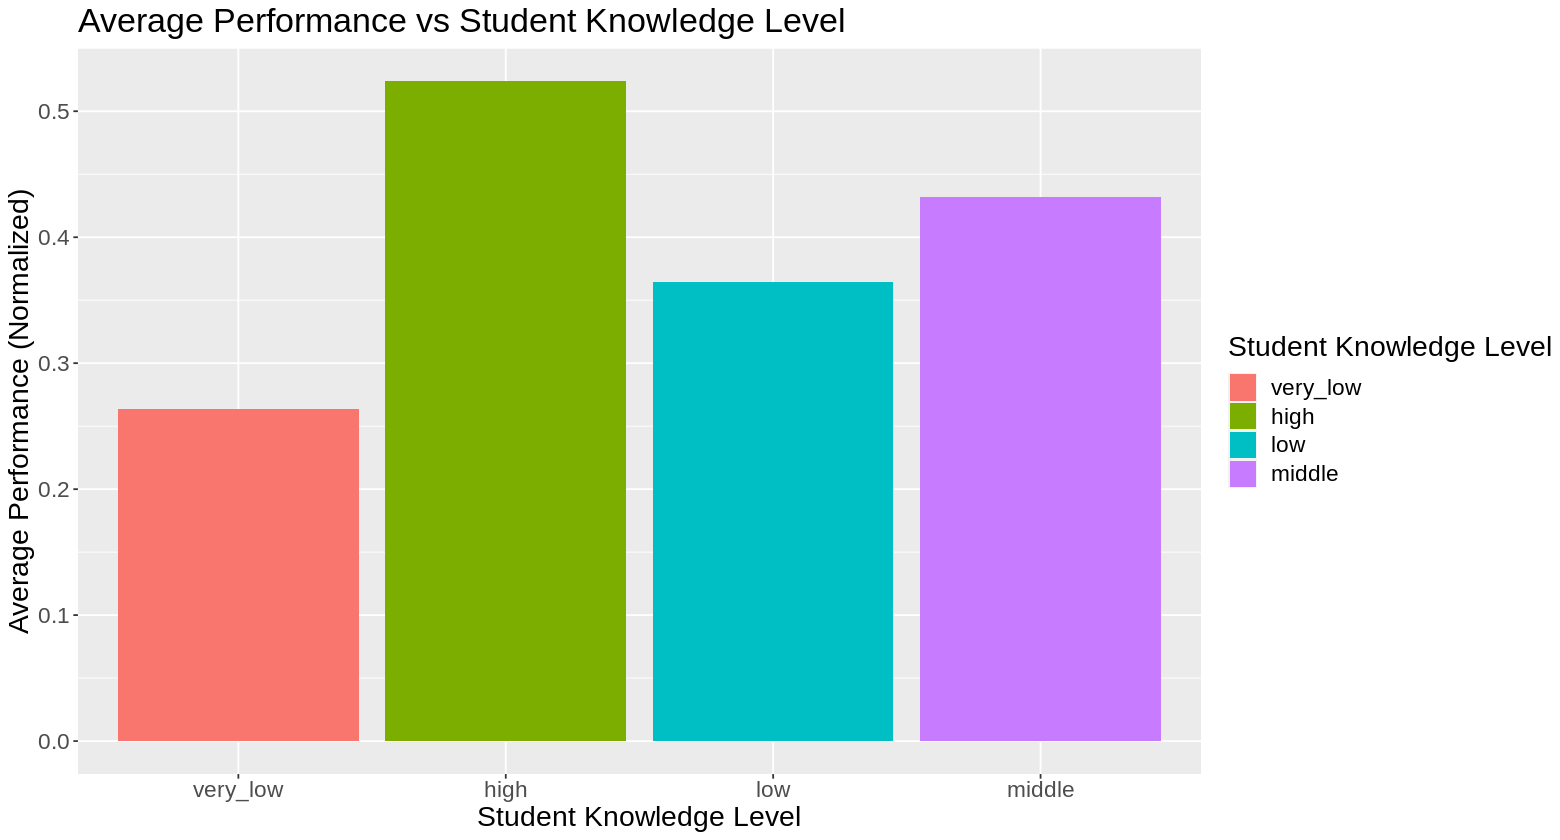

In [67]:
options(repr.plot.width = 13, repr.plot.height = 7)

summary_table %>%
    ggplot(aes(x = SKL, y = avg_performance, fill = SKL)) + 
    geom_bar(stat = 'identity') + 
    labs(x = 'Student Knowledge Level', y = 'Average Performance (Normalized)', fill = 'Student Knowledge Level') + 
    ggtitle('Average Performance vs Student Knowledge Level') + 
    theme(text = element_text(size = 17))